In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%pylab inline

import numpy as np
import sklearn
import pandas as pd
from sklearn.decomposition import PCA
import os

env_var = os.environ
os.environ["LACE_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE"
os.environ["LACE_MANAGER_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE_manager"

import matplotlib.pyplot as plt
# make pretty plots
font = {'size'   : 12}
matplotlib.rc('font', **font)
plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# our modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.cosmo import camb_cosmo
from lace.cosmo import fit_linP
from lace.emulator import poly_p1d
from lace.emulator import pd_archive

# read eBOSS P1D to plot relative error bars
from lace_manager.data import data_Chabanier2019
chab=data_Chabanier2019.P1D_Chabanier2019()

# Set up cosmology to get eBOSS k_max at each z where we have data
cosmo_fid=camb_cosmo.get_cosmology()

 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/lace-1.0.1-py3.10.egg/lace/emulator/pd_archive.py:177: SyntaxWarning:"is" with a literal. Did you mean "=="?
 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/lace-1.0.1-py3.10.egg/lace/emulator/pd_archive.py:177: SyntaxWarning:"is" with a literal. Did you mean "=="?


In [3]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
def sigma68(data): return 0.5*(np.nanquantile(data,q = 0.84,axis = 0) - np.nanquantile(data,q = 0.16,axis = 0))

## DEFINE NETWORK AND TRAINING PROCESS

In [5]:
class MDNemulator_polyfit(torch.nn.Module):
    def __init__(self, nhidden, npca):
        super().__init__()
        self.inputlay = torch.nn.Sequential(nn.Linear(6 ,20),nn.LeakyReLU(0.5))
        
        params = np.linspace(20,100,nhidden)
        modules = []
        for k in range(nhidden-1):
            modules.append(nn.Linear(int(params[k]) ,int(params[k+1])))
            modules.append(nn.LeakyReLU(0.5))  
        self.hiddenlay = nn.Sequential(*modules)
                
        self.means = torch.nn.Sequential(nn.Linear(100 ,50),nn.LeakyReLU(0.5),nn.Linear(50, npca))
        self.stds = torch.nn.Sequential(nn.Linear(100 ,50),nn.LeakyReLU(0.5),nn.Linear(50 ,npca))
        
    def forward(self, inp):
        
        x = self.inputlay(inp)
        x = self.hiddenlay(x)
        p1d = self.means(x)
        logerrp1d = self.stds(x)

        
        return p1d,logerrp1d   

In [6]:
def train_mdn_pca(net, loader, transformation_matrix, npca, data_mean, epochs, step_size, lr0):
    optimizer = optim.Adam(net.parameters(), lr=lr0, weight_decay=1e-2)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

    transformation_matrix = torch.Tensor(transformation_matrix).cuda()
    data_mean = torch.Tensor(data_mean).cuda()
    
    for epoch in range(epochs):
        for datain, p1D_true, PCAtrue in loader:
            optimizer.zero_grad() 
            
            PCAPred,PCA_logerr = net(datain.cuda())
            PCA_logerr = torch.clamp(PCA_logerr,-10,5)
            PCAerr = torch.exp(PCA_logerr)
            
            #print(PCAPred.shape, PCAtrue.shape)
            
            P1Dpred = torch.matmul(PCAPred,transformation_matrix) + data_mean
            P1Derr = torch.abs(torch.matmul(PCAerr,transformation_matrix))
                        
            
            P1Dlogerr = torch.log(P1Derr)
            
                                  
            log_prob = ((P1Dpred - p1D_true.cuda()) / P1Derr).pow(2) + 2*P1Dlogerr#
            
            loss = torch.sum(log_prob,1)
            loss = torch.mean(loss,0)
                        
            log_prob = ((PCAPred - PCAtrue.reshape(len(PCAtrue),npca).cuda()) / PCAerr).pow(2) + 2*PCA_logerr#
                        
            loss = torch.nanmean(log_prob,1)
            loss = torch.nanmean(loss,0)
            
            loss.backward()
            optimizer.step()

        scheduler.step()
        
        if epoch == epochs: 
            print((PCAPred.cpu()/PCAtrue).mean())
        
    return net

## GET DATA

In [7]:
def sort_dict(dct,keys):
    for d in dct:
        sorted_d = {k: d[k] for k in keys}
        d.clear()
        d.update(sorted_d)
    return dct
    

In [8]:
def get_training_kMpc(training, Nk=37):
    key_to_extract = ['k_Mpc']
    training_k = [{ key:value for key,value in training.data[i].items() if key in key_to_extract} for i in range(len(training.data))]
    training_k = [list(training_k[i].values())[0][1:(Nk+1)].tolist() for i in range(len(training.data))]
    training_k = np.array(training_k)[0,:]
    training_k = torch.Tensor(training_k)
    
    return training_k

In [9]:
def get_training_data(archive,emuparams,paramLims, key_av=None):
    """
    Given an archive and key_av, it obtains the training data based on self.emuparams
    Sorts the training data according to self.emuparams and scales the data based on self.paramLims
    Finally, it returns the training data as a torch.Tensor object.
    """
    training_data = [{key: value for key, value in getattr(archive, key_av)[i].items() if key in emuparams} for i in range(len(getattr(archive, key_av)))]
    training_data = sort_dict(training_data, emuparams)
    training_data = [list(training_data[i].values()) for i in range(len(getattr(archive, key_av)))]

    training_data = np.array(training_data)
    mf,DeltaP = training_data[:,2], training_data[:,0]
    
    training_data = (training_data - paramLims[:, 0]) / (paramLims[:, 1] - paramLims[:, 0]) - 0.5
    training_data = torch.Tensor(training_data)

    return training_data, mf, DeltaP


In [10]:
def get_training_pd1(archive, mf, DeltaP, Nk=32, key_av=None,scaling=True):
    """
    Given an archive and key_av, it obtains the p1d_Mpc values from the training data and scales it.
    Finally, it returns the scaled values as a torch.Tensor object along with the scaling factor.
    """
    training_label = [{key: value for key, value in getattr(archive, key_av)[i].items() if key in ['p1d_Mpc']} for i in range(len(getattr(archive, key_av)))]
    training_label = [list(training_label[i].values())[0][1:(Nk+1)].tolist() for i in range(len(getattr(archive, key_av)))]

    training_label = np.array(training_label)
    
    if scaling==True:
        training_label = np.array(training_label*mf[:,None]*DeltaP[:,None])
        
    yscalings = np.median(training_label)
    training_label = np.log10(training_label / yscalings)
    training_label = torch.Tensor(training_label)


    return training_label, yscalings

In [11]:
def recover_p1d_fromPCA(pca_comp, transformation_matrix, data_mean):
    projected_data = np.dot(pca_comp, transformation_matrix)
    recovered_data = projected_data + data_mean
    return recovered_data
 

In [12]:
def obtain_paramLims(emuparams,zmax):
    """
    Obtain parameter limits for the emulator training data.

    Returns:
        None
    """
    sim_all = pd_archive.archivePD(z_max=zmax)
    sim_all.average_over_samples(flag="all")
    sim_all.average_over_samples(flag="phases")
    sim_all.average_over_samples(flag="axes")

    data = [{key: value for key, value in sim_all.data_av_all[i].items() if key in emuparams} for i in range(len(sim_all.data_av_all))]
    data = sort_dict(data, emuparams)  # sort the data by emulator parameters
    data = [list(data[i].values()) for i in range(len(sim_all.data_av_all))]  # convert the sorted dictionaries to a list
    data = np.array(data)  # convert the list to a NumPy array

    min_ = data.min(0)  # compute the minimum value of each parameter
    max_ = data.max(0)  # compute the maximum value of each parameter
    paramlims = np.concatenate((min_.reshape(len(min_),1), max_.reshape(len(max_),1)), 1)  # concatenate the minimum and maximum values into a NumPy array
    return paramlims  # assign the parameter limits to the class attribute

## LEAVE ONE OUT

In [63]:
def leave_one_out_rbf(npca, emuparams, paramlims, initial_weights):
    """ This will loop over each simulation in the suite. It will load all other simulations
    as training data, and use the default hyperparameters to make an emulator prediction.
    It then calculates the mean and variance of the prediction/truth ratio, and the mean
    and the variance of the fractional error as a function of k and z"""
    ## Data arrays
    Nk=32
    Nz=11
    print(npca)
    fractional_error=np.zeros((Nsim,Nz,Nk))
    emu_p1derrs=np.zeros((Nsim,Nz,Nk))
    emu_p1ds = np.zeros((Nsim,Nz,Nk))
    emu_p1ds_transformed = np.zeros((Nsim,Nz,Nk))
    true_p1ds=np.zeros((Nsim,Nz,Nk))
    coeffs = np.zeros((Nsim,Nz,npca))
    coeffs_error = np.zeros((Nsim,Nz,npca))

    for simnum in range(0,Nsim):#Nsim
        print('Starting sim:', simnum)
        
        # archive containing only a given simulation
        truth=pd_archive.archivePD(z_max=zmax,pick_sim=simnum,nsamples=30)
        truth.average_over_samples(flag="all")
        truth = [d for d in truth.data_av_all if d['ind_tau'] == 0] 

        # archive containing all other simulations
        training=pd_archive.archivePD(z_max=zmax,drop_sim=simnum,nsamples=30)
        training.average_over_samples(flag="all")
        training.average_over_samples(flag="phases")
        training.average_over_samples(flag="axes")
        
        training.input_emulator(flag="all")
        training.input_emulator(flag="phases")
        training.input_emulator(flag="axes")

        
        training_data_all, mf, DeltaP = get_training_data(training,emuparams,paramlims, key_av='data_input_all')
        training_label_all,yscalings = get_training_pd1(training,mf,DeltaP, key_av='data_input_all')
        
        training_data_axes, mf, DeltaP = get_training_data(training,emuparams,paramlims, key_av='data_input_axes')
        training_label_axes,yscalings = get_training_pd1(training,mf,DeltaP, key_av='data_input_axes')
        
        training_data_phases, mf, DeltaP = get_training_data(training,emuparams,paramlims, key_av='data_input_phases')
        training_label_phases,yscalings = get_training_pd1(training,mf,DeltaP, key_av='data_input_phases')
        
        training_data = torch.concat((training_data_axes,training_data_phases),0)
        training_label = torch.concat((training_label_axes,training_label_phases),0)
        
        
        data_mean = np.mean(training_label.numpy(),0)
        
        
        pca = PCA(n_components=npca)#n_components=npca
        training_label_fit = pca.fit_transform(training_label.numpy())
        training_label_fit = torch.Tensor(training_label_fit)
        transformation_matrix = pca.components_

        
        print('Training network on %s'%len(training_data))
                
        training_k = get_training_kMpc(training)
                
        data_training = TensorDataset(training_data,training_label,training_label_fit)
        loader_train = DataLoader(data_training, batch_size=100, shuffle = True)
        
    
        # create emulator from training set
        mdnemu = MDNemulator_polyfit(5,npca).cuda()
        mdnemu.load_state_dict(initial_weights)
        mdnemu = train_mdn_pca(mdnemu, loader_train, transformation_matrix,npca, data_mean, epochs=300, step_size=250, lr0=1e-3)#300 250
        mdnemu = mdnemu.eval()


        
        with torch.no_grad():
            # for each entry (z) in truth/test simulation, compute residuals
            for aa,item in enumerate(truth):
                # figure out redshift for this entry
                z=item["z"]
                # true p1d (some sims have an extra k bin, so we need to define mask again)
                true_k=item["k_Mpc"]
                k_mask=(true_k<kmax_Mpc_test) & (true_k>0)
                true_p1d=item["p1d_Mpc"][k_mask]#[:self.Nk_test]
                #assert len(true_p1d)==self.Nk_test
                true_k = true_k[k_mask]
                
                true_p1d_pca = pca.transform(true_p1d.reshape(1,32))
                true_p1d_pca_recons = true_p1d_pca @ transformation_matrix + data_mean#.numpy()
                

                log_KMpc = torch.log10(torch.Tensor(true_k)).cuda()

                # for each entry, figure emulator parameter describing it (labels)
                emu_call={}
                for param in emuparams:
                    emu_call[param]=item[param]


                emu_call = list(emu_call.values())
                emu_call = np.array(emu_call)
                mf = emu_call[2]
                DeltaP = emu_call[0]
                
                #emu_call = (emu_call -meanparams) / stdparams
                emu_call = (emu_call - paramlims[:,0]) / (paramlims[:,1] - paramlims[:,0]) - 0.5
                emu_call = torch.Tensor(emu_call).unsqueeze(0)

                # ask emulator to emulate P1D (and its uncertainty)
                PCAPred,PCA_logerr = mdnemu(emu_call.cuda())
                PCA_logerr = torch.clamp(PCA_logerr,-10,5)
                PCAerr = torch.exp(PCA_logerr)
                
                PCAPred = PCAPred.detach().cpu().numpy().flatten()#*pca_scaling
                PCAerr = PCAerr.detach().cpu().numpy().flatten()#*pca_scaling
                
                                
                       
                emu_p1d = PCAPred @ transformation_matrix + data_mean#.numpy()
                emu_p1derr = transformation_matrix.T @ PCAerr
                
                                
                
                emu_p1derr = 10**(emu_p1d)*np.log(10)*yscalings*emu_p1derr
                #emu_p1d = 10**(emu_p1d) * yscalings
                emu_p1d = 10**(emu_p1d) * yscalings / (mf*DeltaP)
                
                

                
                fractional_error[simnum,aa,:]=emu_p1d/true_p1d
                emu_p1derrs[simnum,aa,:]=emu_p1derr
                emu_p1ds[simnum,aa,:]=emu_p1d
                true_p1ds[simnum,aa,:]=true_p1d
                coeffs[simnum,aa]=PCAPred
                coeffs_error[simnum,aa]=PCAerr

                


            print('Mean fractional error:', fractional_error[simnum].mean())
            print('Std fractional error:', fractional_error[simnum].std())
            
    return fractional_error, np.mean(fractional_error,axis=0),np.std(fractional_error,axis=0), emu_p1ds, true_p1ds,  emu_p1derrs, coeffs,coeffs_error,emu_p1ds_transformed

## RUN

In [13]:
emuparams = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
emu_label = ['p1d_Mpc']
emu_kmax_Mpc=8
kmax_Mpc_train=3
kmax_Mpc_test=3
zmax = 4.5
Nsim=30
npca = 4

paramLims = obtain_paramLims(emuparams,zmax)

sim = pd_archive.archivePD(z_max=zmax,pick_sim=0,nsamples=30)
sim_kMpc = get_training_kMpc(sim)

In [14]:
archive = pd_archive.archivePD(z_max=zmax,nsamples=30)
_, mf, DeltaP = get_training_data(archive,emuparams,paramLims, key_av='data')
training_label,_ =  get_training_pd1(archive, mf, DeltaP, Nk=32, key_av='data',scaling=True)
training_label_nosc,_ =  get_training_pd1(archive, mf, DeltaP, Nk=32, key_av='data',scaling=False)

In [15]:
npca = 5
pca = PCA(n_components=npca)#n_components=npca
training_label_fit = pca.fit_transform(training_label)
eigenvalues = pca.explained_variance_ratio_

pca = PCA(n_components=npca)#n_components=npca
training_label_fit = pca.fit_transform(training_label_nosc)
eigenvalues_nosc = pca.explained_variance_ratio_


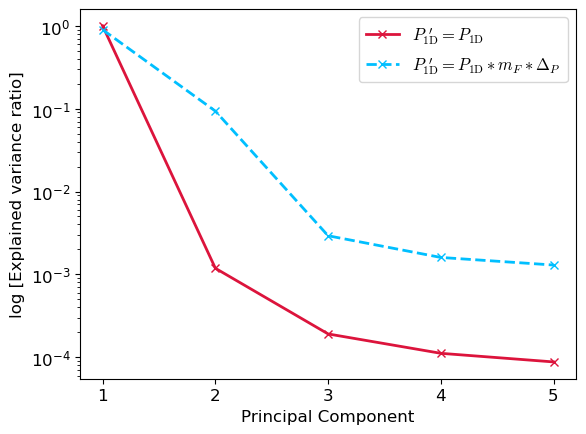

In [26]:
# plot the scree plot
plt.plot(range(1, npca+1), eigenvalues_nosc, 'x-', linewidth=2, color = 'crimson', label = r'$P^{\ \prime}_{\rm 1D} = P_{\rm 1D}$')
plt.plot(range(1, npca+1), eigenvalues, 'x--', linewidth=2, color = 'deepskyblue', label = r'$P^{\ \prime}_{\rm 1D} = P_{\rm 1D}*m_F*\Delta_P$')


plt.xlabel('Principal Component')# fontsize = 14)
plt.ylabel(r'log [Explained variance ratio]')# fontsize = 14)

plt.xticks(np.arange(1,6,1))#,fontsize = 12)
#plt.yticks(fontsize = 12)

plt.yscale('log')
plt.legend()#fontsize=12

plt.savefig('PCA_eighenvalues.pdf', bbox_inches = 'tight')
plt.show()


In [67]:
emuparams = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
emu_label = ['p1d_Mpc']
emu_kmax_Mpc=8
kmax_Mpc_train=3
kmax_Mpc_test=3
zmax = 4.5
Nsim=30
npca = 4

paramLims = obtain_paramLims(emuparams,zmax)

sim = pd_archive.archivePD(z_max=zmax,pick_sim=0,nsamples=30)
sim_kMpc = get_training_kMpc(sim)

In [68]:
mdnemu = MDNemulator_polyfit(5,npca).cuda()
initial_weights = mdnemu.state_dict()
fractional_error,mean_ratio_rbf,std_ratio_rbf, emu_p1ds, true_p1ds,  emu_p1derrs,  coeffs,coeffs_error,emu_p1ds_transformed=leave_one_out_rbf(npca, emuparams, paramLims, initial_weights)


4
Starting sim: 0
Training network on 11165
Mean fractional error: 1.0257384955125615
Std fractional error: 0.011266939857764802
Starting sim: 1
Training network on 11165
Mean fractional error: 1.0371847992645147
Std fractional error: 0.01765108997803507
Starting sim: 2
Training network on 11165
Mean fractional error: 1.0078074768275138
Std fractional error: 0.014688373947419576
Starting sim: 3
Training network on 11165
Mean fractional error: 1.0108897498453913
Std fractional error: 0.00955959955070182
Starting sim: 4
Training network on 11165
Mean fractional error: 1.0057596794531882
Std fractional error: 0.009521928596331858
Starting sim: 5
Training network on 11165
Mean fractional error: 1.0214899101870178
Std fractional error: 0.010820653949767712
Starting sim: 6
Training network on 11165
Mean fractional error: 1.037020838582581
Std fractional error: 0.011127070351694683
Starting sim: 7
Training network on 11165
Mean fractional error: 1.0086790702275856
Std fractional error: 0.0105

In [69]:
np.savetxt('fractional_errors/PCA/fractional_error_4pca.txt', fractional_error.reshape(30,32*11))

In [216]:
np.savetxt('fractional_errors/PCA/coeffs_4pca.txt', coeffs.reshape(30,4*11))

## PLOTS

### RECONSTRUCTION FROM TRUE PCA'S

In [29]:
def recons_p1d_acc(training,npca,scaling=True):
    

    #training_data_axes, mf, DeltaP = get_training_data(training,emuparams,paramLims, key_av='data_input_axes')
    #training_label_axes,yscalings = get_training_pd1(training,mf,DeltaP, key_av='data_input_axes')
        
    #training_data_phases, mf, DeltaP = get_training_data(training,emuparams,paramLims, key_av='data_input_phases')
    #training_label_phases,yscalings = get_training_pd1(training,mf,DeltaP, key_av='data_input_phases')
    
    #training_label = np.concatenate((training_label_axes,training_label_phases),0)
    
    training_data, mf, DeltaP = get_training_data(training,emuparams,paramLims, key_av='data_av_all')
    training_label,yscalings = get_training_pd1(training,mf,DeltaP, key_av='data_av_all',scaling=scaling)
    
    training_label = training_label.numpy()
    
    data_mean = training_label.mean(0)
        
    n_components = training_label.shape[1]
    pca = PCA(n_components=npca)
    training_label_pca=pca.fit_transform(training_label)
    
    transformation_matrix = pca.components_
    
    training_label_pca = training_label_pca[:,0:npca]
            
    training_label_reconstructed = recover_p1d_fromPCA(training_label_pca.reshape(len(training_label_pca),npca), transformation_matrix, data_mean)
    
    
    print('mean',np.mean(training_label_reconstructed[0]/ training_label[0]), 'std', np.std(training_label_reconstructed[0]/ training_label[0]))

    return training_label_reconstructed,training_label

In [30]:
training=pd_archive.archivePD(z_max=zmax,nsamples=30)
training.average_over_samples(flag="all")
training.average_over_samples(flag="phases")
training.average_over_samples(flag="axes")

training.input_emulator(flag="all")
training.input_emulator(flag="phases")
training.input_emulator(flag="axes")

training.data_av_all = [d for d in training.data_av_all if d['ind_tau'] == 0] 

In [31]:
npca = 9
error_recons = np.zeros(shape = (npca,30*11,32))
for numpca in range(1,10):
    recons_p1d, true_p1d = recons_p1d_acc(training,numpca,scaling=True)
    error_recons[numpca-1] = (recons_p1d.reshape(30*11,32) / true_p1d.reshape(30*11,32) -1 )*100

mean 1.1244003 std 0.47534162
mean 0.99016654 std 0.1538204
mean 1.0017481 std 0.007957493
mean 0.9997953 std 0.014213378
mean 1.0002587 std 0.008794742
mean 0.9972935 std 0.006895422
mean 0.99797857 std 0.0053493376
mean 0.99786544 std 0.0056801788
mean 0.9986621 std 0.0068822433


In [46]:
fractional_error_1pca = np.loadtxt('fractional_errors/PCA/fractional_error_1pca.txt').reshape(30,11,32)
fractional_error_2pca = np.loadtxt('fractional_errors/PCA/fractional_error_2pca.txt').reshape(30,11,32)
fractional_error_3pca = np.loadtxt('fractional_errors/PCA/fractional_error_3pca.txt').reshape(30,11,32)
fractional_error_4pca = np.loadtxt('fractional_errors/PCA/fractional_error_4pca.txt').reshape(30,11,32)

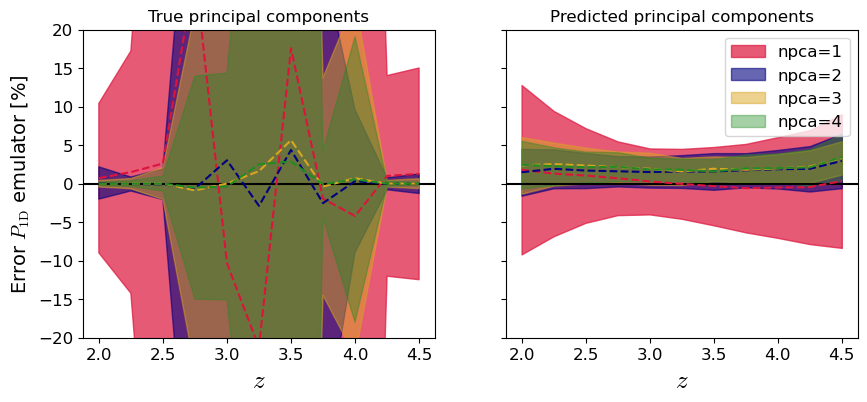

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
list_ratios = [fractional_error_1pca,fractional_error_2pca,fractional_error_3pca,fractional_error_4pca]#,fractional_error_5pca]
colors = ['crimson', 'navy', 'goldenrod', 'forestgreen', 'lightpink']
npcas = [1,2,3,4]
alphas = [0.7,0.6,0.5,0.4]
sim_zs = np.arange(2,4.6,0.25)
# First panel

ax1.axhline(y=0,color = 'black')
ax2.axhline(y=0,color = 'black')
for k in range(4):
    s = error_recons[k]
    mean = np.nanmean(np.swapaxes(s,0,1).reshape(11,30*32),1)
    std = np.nanstd(np.swapaxes(s,0,1).reshape(11,30*32),1)
    
    ax1.fill_between(sim_zs,mean-std, mean+std, label = 'npca=%s'%npcas[k], color = colors[k], alpha = alphas[k])
    ax1.plot(sim_zs,mean, color = colors[k], ls ='--')

# Second panel
for k in range(4):
    s = (list_ratios[k]-1)*100
    mean = np.nanmean(np.swapaxes(s,0,1).reshape(11,30*32),1)
    std = np.nanstd(np.swapaxes(s,0,1).reshape(11,30*32),1)
    
    ax2.fill_between(sim_zs,mean-std, mean+std, label = 'npca=%s'%npcas[k], color = colors[k], alpha = alphas[k])
    ax2.plot(sim_zs,mean, color = colors[k], ls ='--')


ax1.set_xlabel(r'$z$', fontsize = 18)
ax2.set_xlabel(r'$z$', fontsize = 18)
ax1.set_title('True principal components', fontsize = 12)
ax2.set_title('Predicted principal components', fontsize = 12)
ax2.set_ylim(-20,20)

plt.legend()

ax1.set_ylabel(r'Error $P_{\rm 1D}$ emulator [%]', fontsize = 14)


plt.savefig('PCA_precision_predtrue.pdf', bbox_inches = 'tight')



In [48]:
s

array([[[-0.06244108,  0.83129057,  0.42450996, ...,  0.98482565,
          1.00004982,  1.15065524],
        [ 0.82735486,  2.06420577,  1.52386355, ...,  2.38088929,
          2.41550034,  2.53018625],
        [ 2.42064522,  3.59317782,  3.00058758, ...,  4.04551474,
          4.39230784,  4.27494262],
        ...,
        [ 3.44484197,  2.69079787,  2.9899546 , ...,  2.97644552,
          2.68583005,  2.37670548],
        [ 4.44716684,  3.34299842,  3.67887023, ...,  2.75136722,
          2.68283167,  2.47960851],
        [ 6.72148585,  5.09201342,  5.39863823, ...,  4.10917291,
          3.94567492,  3.92965661]],

       [[-0.06596203,  2.5969007 ,  4.5019706 , ...,  3.86115868,
          3.8592319 ,  3.75994272],
        [ 4.22894814,  5.89595209,  7.10892253, ...,  5.62316827,
          5.62629962,  5.59214793],
        [ 4.47529243,  5.45375688,  6.33046857, ...,  4.80211158,
          4.68739292,  4.65187981],
        ...,
        [ 4.69488193,  3.54106584,  4.09046309, ...,  

## Compare PCA's

In [227]:
coeffs = np.loadtxt('fractional_errors/PCA/coeffs_4pca.txt').reshape(30*11,4)

In [228]:
training_data, mf, DeltaP = get_training_data(training,emuparams,paramLims, key_av='data_av_all')
training_label,yscalings = get_training_pd1(training,mf,DeltaP, key_av='data_av_all',scaling=True)

training_label = training_label.numpy()

In [229]:
npca=4
n_components = training_label.shape[1]
pca = PCA(n_components=npca)
training_label_pca=pca.fit_transform(training_label)

 /tmp/ipykernel_149/4275571816.py:7: UserWarning:No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


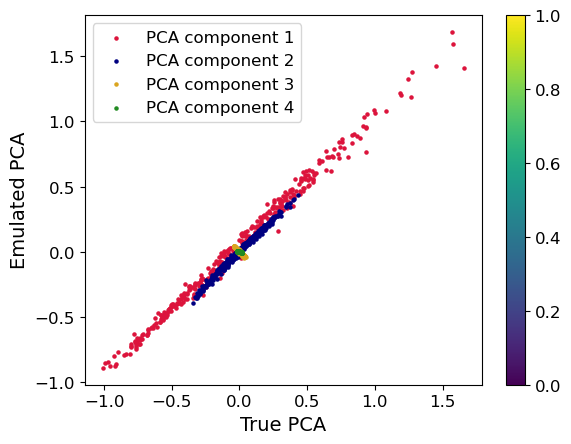

In [248]:
colors = ['crimson', 'navy', 'goldenrod', 'forestgreen', 'lightpink']
npcas = [1,2,3,4]
alphas = [0.7,0.6,0.5,0.4]

# First panel
for k in range(4):
    plt.scatter(training_label_pca[:,k].flatten(), coeffs[:,k].flatten(), c = colors[k], s = 5, vmin = -5,vmax = 5, label = f'PCA component {npcas[k]}')

plt.colorbar()
plt.legend()

plt.xlabel('True PCA', fontsize = 14)
plt.ylabel('Emulated PCA', fontsize = 14)

plt.savefig('scatter_polycoeffs.pdf', bbox_inches = 'tight')